<a href="https://colab.research.google.com/github/chrisjmccormick/llm-tuning-examples/blob/main/continuing-pre-training/Continuing%20Pre-Training%20on%20Raw%20Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ▂▂▂▂▂▂▂▂▂▂▂▂

# **Introduction**


This blog post builds upon a community notebook from Unsloth titled [*Mistral 7B Text Completion - Raw Text Training Full Example*](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

I went through the original in one of my "Weekly Walkthrough" sessions, learned more about Continued Pre-Training (CPT) in the process, and decided to create a post from it with more code comments and to share the insights we gathered.

The code in the notebook remains largely unchanged, just with more comments and explanation.





**Objective & Dataset**

The goal of the pre-training in this Notebook is to have the LLM write in the style of the `TinyStories` dataset, created by Ronen Eldan at Microsoft Research.

From the abstract of the paper [here](https://arxiv.org/abs/2305.07759), this dataset was actually designed to train tiny language models (e.g. under 10M parameters... For comparison, even BERT is 110M parameters!).

It consists of 2.5M very short stories that were generated by GPT and use the vocabulary of a 4-year old.

Here's an example:

> One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
>
> Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
>
> Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.


It's on the HuggingFace datasets repository [here](https://huggingface.co/datasets/roneneldan/TinyStories).


**Continued Pretraining (CPT)**

**Pre-training** is done with a "self-supervised" objective: given some text, predict what token comes next ("next-token prediction"). It's "self-supervised" because all we need is raw text, no other labeling required!

Companies like Meta and Mistral perform this step on datasets of trillions of tokens to create and share the base models we use like Llama 3 8b and Mistral 7b.

> Side Note: Pre-training a base model is an incredibly resource-intensive process. The 8-billion parameter version of Llama 3 was trained for _1.3M GPU hours!_ (from [here](https://huggingface.co/meta-llama/Meta-Llama-3-8B). It's only about 52 hours of training, though, if you divide that by the size of their compute cluster... _25,000 H100 GPUs_ 🤯 (from [here](https://blogs.nvidia.com/blog/meta-llama3-inference-acceleration/)).  

CPT is where we take a base model and further train it using this same "next token prediction" task, but on new text.

## i. **Where CPT is Used**


To understand why you might want to do this, let's look at an example from the **legal domain**.

I poked around online for some ugly looking legal text, and ended up on the Affordable Care Act ([here](https://www.govinfo.gov/app/details/PLAW-111publ148), plain text [here](https://www.govinfo.gov/content/pkg/PLAW-111publ148/html/PLAW-111publ148.htm)).

Check out this excerpt:



```
SEC. 2713. <<NOTE: 42 USC 300gg-13.>> COVERAGE OF PREVENTIVE HEALTH
SERVICES.

    (a) In General.--A group health plan and a health insurance issuer
offering group or individual health insurance coverage shall, at a
minimum provide coverage for and shall not impose any cost sharing
requirements for--
            (1) evidence-based items or services that have in effect a
        rating of `A' or `B' in the current recommendations of the
        United States Preventive Services Task Force;
            (2) immunizations that have in effect a recommendation
        from the Advisory Committee on Immunization Practices of the
        Centers for Disease Control and Prevention with respect to the
        individual involved; and
        ...
```


This excerpt demonstrates two kinds of "knowledge" that a base model might be lacking:


**Domain Knowledge**

In order to understand terminology like:

1. "evidence-based items",
2. "rating of 'A' or 'B'", and
3. "the United States Preventive Services Task Force",

the model will need to be familiar with US healthcare policy and relevant government orginizations.

So domain knowledge includes things like learning about new "entities" (people, organizations, projects, ...), and new "jargon".

> Side Note: Since medical and legal text do exist all over the internet, and huge models like GPT-4 seem quite knowledgable, I wonder if a more interesting use case would be getting the model to learn about the projects and acronyms and terminology that's only used internally within a company?


**Out-of-Distribution (OOD) Text**

The text clearly follows some strict **formatting** conventions, like the section header `SEC. 2713` and the legal citation `<<NOTE: 42 USC 300gg-13.>>`

It also includes some specific **phrasing** conventions, e.g., "shall, at a minimum provide coverage for". The model understands all of those words, but it's written in a unique **style** that you may want to teach the model to be better at.

Base models are trained to predict the next token by outputting a probability distribution over their entire vocabulary. You can combine the probabilities for each token in a paragraph to estimate how likely the model thinks the text is overall. When the format or style of the text is something the model hasn’t seen much of during training, it might assign low probabilities to the tokens. This makes the text "**out of distribution**" because it doesn’t match the patterns the model saw during training.




**Summary**

Overall, I think new domains are about knowledge, and OOD domains are about new formats and writing styles.

## ii. **Training on Raw Text**

One of the best things about CPT is that it's "**self-supervised**", meaning no additional human labeling is required.

All you need is **raw text** from your domain, and every token in the text becomes a training sample (i.e., for each token, the prior text is the input and the next token is the label).

If you have a big repository of legal documents containing 100 million tokens, then you have a training set with _100 million samples_.

> Side Note: The Affordable Care Act is ~60k lines long and ~400k "words", so 100M tokens doesn't seem like too big of a stretch!

## iii. CPT vs. Fine-Tuning


While CPT can use raw text to pick up new knowledge, formats, and styles, **Fine-Tuning** requires labeled data.

CPT is Self-Supervised and Fine-Tuning is Supervised, and lately I've been seeing it more explicitly named as "Supervised Fine-Tuning" (**SFT**).

> Side Note: The name "fine-tuning" just implies that you're doing a much smaller training run than what was used to create the base model, and you could do this with labeled data or raw text, so I think it makes sense to use the explicit "SFT" name when refering to training with labeled data.

**Specializing**

Essentially, I think SFT is about improving the model's performance on tasks and domains that it's already familiar with (either from its original pre-training or from additional CPT that you've done).

The mathematics of supervised training _guarantee_ that it will improve the model's performance on the _training set_. The question is, how badly did it "overfit" the task and the knowledge?

Overfitting the task means the model has lost performance on other tasks, and overfitting the knowledge means the model has frogotten other things.

We can apply techniques such as LoRA to help minimize this problem, but I think it's probably safe to assume that the model's getting worse at _something_.

From what I've gathered, here's where I think you might use CPT and/or SFT:

| Reason for Training           | CPT | SFT |
|-------------------------------|-----|-----|
| Learn new style or format     | x   |     |
| Learn new knowledge           | x   |     |
| Specialize on style or format | x   | x   |
| Specialize on knowledge       | x   | x   |
| Specialize on task            |     | x   |

We'll see in this example that CPT on a small amount of data is enough to get it to specialize on a particular writing style.

TODO - I asked GPT to explain the differences. I thought about re-writing it, but it feels like a really solid summary that I'm not sure how much I can improve on, so I'm just including it here in full.

---

****1. Fine-Tuning****

Fine-tuning involves training the model on a smaller, task-specific dataset, often with supervised labels or targeted examples.

****Advantages:****

- **Task-Specific Adaptation:** Fine-tuning is excellent for making the model highly specialized in a task, such as sentiment analysis, summarization, or medical question-answering.
- **Data Efficiency:** Fine-tuning can work well even with relatively small datasets compared to pretraining.
- **Precision:** It allows the model to focus narrowly on the task or domain of interest.

****Limitations:****

- **Limited Generalization:** Fine-tuning typically focuses on a specific task or dataset, which might lead to overfitting. The model may struggle to generalize to broader contexts within the domain.
- **Less Broad Knowledge Acquisition:** Fine-tuning does not expose the model to large amounts of diverse data in the new domain. If the domain is vast and heterogeneous, the model's understanding might remain incomplete.

---

****2. Continued Pretraining on Raw Text****

This involves training the model further using its original pretraining objective (e.g., next-token prediction) on raw text data from the new domain or OOD domain.

****Advantages:****

- **Broader Knowledge Acquisition:** By training on raw text, the model absorbs a wide range of linguistic patterns, facts, and context from the new domain.
- **Improved Generalization:** This method helps the model adapt not just to specific tasks but also to general use cases in the new domain or OOD data. It can perform better across various tasks without task-specific labels.
- **Alignment with Pretraining Objective:** Continued pretraining aligns with the original self-supervised learning objective, making it efficient for improving foundational knowledge in the new domain.

****Limitations:****

- **Resource Intensive:** Continued pretraining often requires more data, computational resources, and time than fine-tuning.
- **Less Task-Specific:** It doesn't directly optimize for a specific task or goal; additional fine-tuning might still be required for high performance on specific tasks.

---

****Which to Choose?****

- **For Adapting to New Domains:**
  - Use **continued pretraining on raw text** if you need the model to acquire broad, unsupervised domain knowledge.
  - Use **fine-tuning** if the goal is to achieve high performance on specific tasks within the domain and you already have task-specific datasets.

- **For Adapting to OOD Domains:**
  - **Continued pretraining** is usually better for OOD domains because it allows the model to adjust to the style, structure, and context of the new data.
  - **Fine-tuning** can still help but might require careful dataset curation to avoid overfitting or missing the broader linguistic shifts.

---

****Hybrid Approach****

In many cases, a combination of the two methods works best:
1. **Continued pretraining** on raw text from the domain or OOD data for foundational adaptation.
2. **Fine-tuning** on a task-specific dataset for targeted performance improvements.

This hybrid strategy leverages the strengths of both approaches: broad knowledge acquisition from pretraining and task-specific optimization from fine-tuning.

## iv. CPT Considerations


**1. Base Models vs. Instruction-Tuned**

The "instruct" versions of models (e.g., "Meta-Llama-3-8B-Instruct" vs. "Meta-Llama-3-8B") have essentially had CPT run on them to change their writing style to be a chatbot, like ChatGPT.

Any kind of CPT we do of our own is going to erase that behavior (unless the raw text we're using is the same style?), so it makes sense to start from the base model rather than the "instruct" version.

(Insight from [here](https://discord.com/channels/1179035537009545276/1179777624986357780/1323167565522014250)).


**2. Learning Rate on Embeddings**



_The Vocabulary Needs Delicate Handling_

An LLM's vocabulary embeddings store knowledge about the meaning and relationship of words.

Since all of the model's complex functionality has been learned around this vocabulary, I think it makes some intuitive sense that modifying these embeddings too much could have an out-sized impact on the overall performance.

I think this is why the embedding layer is often "frozen" during fine-tuning, meaning we don't make any changes to it at all.

For CPT, updating the embeddings makes more sense in order to teach the model new words, or to emphasize the meaning that a word has in our particular context.

One of the ways that we adjust the impact of our training (i.e., how much we change vs. preserve the model) is via the learning rate.


_Aiside: How Learning Rates Work_

When training neural networks, the "learning rate" is how we throttle (speed up or slow down) the impact of each batch of samples on the model.

The learning rate parameter is a tiny fraction, like 1e-4 (which is 1 / 10,000), that we set.

> Side Note: Why are learning rates so tiny? It's because they're relative to the magnitude of the weight values, which also tend to be tiny fractions.

Learning rates follow a "schedule" which gradually decreases the learning rate to zero over the course of the training run.

The learning rate we specify, such as 1e-4, is actually the peak value, and it just gets smaller from there.



_Reducing the Impact to the Vocabulary_

Unsloth supports setting a different learning rate for the embedding matrix versus the rest of the model as a way to decrease the impact of our changes to the embeddings relative to the decoder layers.

The notes suggest that we typically want to set it 2-10x smaller for CPT, and in this example it's set to 1/10th of the learning rate used on the decoder layers.

For further research: I wonder if it reduces the learning rate on the LM head by the same amount, since the vocabulary and LM head are similar / closely related?

**3. LoRA**


LoRA is a fine-tuning technique which serves two main purposes:

1. It substantially reduces the impact our training has on the model, which helps prevent overfitting.
2. It's the only way to do any fine-tuning if we're using quantization to compress the model (which is typically a requirement if we're training on a single GPU).

With LoRA, we add on a small number of additional weights "alongside" the existing ones, and only update those additional weights.



> Side Note: This is easily misunderstood as implying that updating a small fraction of the weights means it will only require a fraction of the memory and compute. The reality is that we still have to compute and store all of the model activations, and backpropagate the error through all of the model weights. It _does_ mean that we only have to store a fraction of the optimizer state. However, when it comes to memory, what really matters is our sequence length.  Once we get to 1,024 tokens or more, the memory savings from LoRA aren't very meaningful.



Quantization + LoRA are a requirement in order for this example to fit within the memory of a free T4 in Colab.

I'm not sure LoRA is a good idea, though, if you're trying to add substantially to the knowledge of the LLM--it seems too limiting.

It seems to be fine for this example, though, where we're just directing the model to write in the style of a children's story.

If you are going to / have to use LoRA, you can allow the model to learn more by increasing the number of LoRA weights, which is determined by the "rank" parameter, `r`.

# ▂▂▂▂▂▂▂▂▂▂▂▂

# **Example Code**

Time for the actual example!

Unsloth largely follows the huggingface transformers paradigm, but does add some new parameters and options.

The introductory fine-tuning example in the Unsloth docs, [here](https://docs.unsloth.ai/basics/tutorial-how-to-finetune-llama-3-and-use-in-ollama#id-5.-parameters-for-finetuning), seems like a solid reference if you're curious about anything I don't cover.

## S1. Installation

**Install Unsloth**

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

**GPU Memory**

`gpu_mem_used`

This function uses the "NVIDIA System Management Interface" `nvidia-smi` command line tool to retrieve the current memory usage.

There's a function in PyTorch, `torch.cuda.memory_allocated()`, but it seems to severely under-report. 🤷‍♂️

In [ ]:
import os
import torch

def gpu_mem_used():
    """
    Returns the current GPU memory usage as a string, e.g., "5.02 GB"
    """

    # This approach doesn't work, because PyTorch only tracks its own memory
    # usage, not the total memory consumption of the GPU.
    #gpu_bytes_used = torch.cuda.memory_allocated()

    # Run the nvidia-smi command line tool to get memory used in megabytes.
    buf = os.popen('nvidia-smi --query-gpu=memory.used, --format=csv,noheader,nounits')

    # It returns an unformated integer number of "MiB" (2^20 bytes).
    gpu_mb_used = float(buf.read())

    # Divide that by 1024 to get GB.
    mem_used = gpu_mb_used / float(1024)

    return ("{0:.2f} GB".format(mem_used))


In [ ]:
print("GPU memory used: {:}".format(gpu_mem_used()))

GPU memory used: 0.00 GB


## S2. Download Model

The `FastLanguageModel` class, which we'll see below, is one of the key places that we're picking up the unsloth-specific stuff.

Otherwise, we'll see that it largely matches the HuggingFace transformers interface.

From the import notes below, it seems like the library actually "patches" transformers--I think that means replacing some of the existing code in the huggingface library?

In [ ]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


**4-bit Quantization**

Quantization is a technique where we compress the model before loading it onto the GPU in order to save space.

The model is still 16-bits--with quantization we have to decompress the matrices back into 16-bits when we want to use them.

It also means that the model weights can't be updated (without breaking the compression scheme), so we must use LoRA in order to fine-tune the model.

In [ ]:
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

**Pre-Quantized Models**

Unsloth releases pre-quantized versions of popular models in order to speed up the download. Quantization is "deterministic"--for a given pre-trained model, the quantized version will always be the same.
They're saving us a step (though it's not compute intense--really we're just saving on download speed).

These models are hosted by huggingfaces model repository. https://huggingface.co/unsloth

In [ ]:
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth


**RoPE Scaling**

_Positional Encoding Vectors_

There's nothing about the self-attention equations that inherently indicates what order the words are in (The order of the rows in the matrix doesn't matter!).

To indicate the word order, we add these special Positional Encoding (PE) vectors to each of the token embeddings, and the LLM is able to recognize the pattern.




_RoPE: Rotational Position Embeddings_

There have been different schemes for defining the PEVs, but the one that's gained prominence lately is RoPE.

The key detail is that the RoPE vectors are all actually the same vector, just rotated different amounts to reflect the different positions in the sequence.

(Note: I haven't studied RoPE thoroughly, so I may be missing some subtle details).



_RoPE Scaling_

When the base model was trained by Meta, Mistral, etc., they trained it with a specific context window length--a specific number of RoPE embeddings.

Let's say the model was trained with 2,048 position embeddings.

It's been found that we can increase this number to, e.g., 4,096 by simply inserting addition RoPE embeddings in between the existing ones (i.e., at an angle that falls between).

Something I'm not 100% clear on is whether this technique makes these new embeddings immediately useable, or if we have to do at least a little bit of additional training in order for the model to adjust its understanding of the PE embeddings.  



_Unsloth Support_

RoPE scaling can be applied to existing pre-trained models, so long as they used RoPE as their positional encoding scheme.

The unsloth comment says that it's supported "internally", which I assume means they take your desired context size, compare it to what the model was trained with, and then add the appropriate number of interpolated RoPE embeddings.

_Questions_

* What does the code do if you try applying this to an older model that didn't use RoPE? Does it throw an error?
* Can you do RoPE scaling and immediately use the model for inference, or does it have to be trained more first?
    

In [ ]:
# From Unsloth: Choose any! We auto support RoPE Scaling internally!
# I'm guessing that if you specify this to be larger than what the model was
# pre-trained with, then unsloth will infer how much scaling is needed to
# accomodate it.
#
# For Mistral 7b, it was trained with a context of 8,192 tokens, so a maximum
# sequence length of 2,048 doesn't require any scaling.
max_seq_length = 2048

**Data Type**

More recent GPUs implement a 16-bit data type called "BFloat16", which allocates the available precision in a way that's better tailored to the needs of deep learning.

The "B" comes from Google Brain, who created it.

The bfloat16 data type can help prevent issues that occur due to "numerical underflow and overflow", where a calculation results in a number that's too small for the data type to represent, or too large.


In [ ]:
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

**Download the Model**

It looks like with Unsloth, as a convenience feature, `from_pretrained` returns both the model _and_ the tokenizer. (The normal hf paradigm is to load these separately--but it's always the same step, so it makes sense to combine them).

Note that, in order to download Mistral, you'll need to:

1. Have a Hugging Face account
2. Accept Mistral's user license
3. Create a huggingface token to link this Notebook to your account (so they can verify that your account has accepted the license).

It looks like if you add your Hugging Face token to your Colab Secrets (the key-shaped icon in the panel on the left), and name it "HF_TOKEN", the code will find it automatically and handle the authorization step.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    # Mistral, version 3, 7b parameters
    model_name = "unsloth/mistral-7b-v0.3", # "unsloth/mistral-7b" for 16bit loading

    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,

    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.1.5: Fast Mistral patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Let's check the GPU memory useage after loading the (quantized!) model.

In [ ]:
gpu_mem_model = gpu_mem_used()

print("GPU memory used: {:}".format(gpu_mem_used()))

GPU memory used: 4.78 GB


<a name="Data"></a>
## S3. Data Prep


From the original Notebook:

> We now use the Tiny Stories dataset from https://huggingface.co/datasets/roneneldan/TinyStories. We only sample the first 2500 rows to speed training up. We must add `EOS_TOKEN` or `tokenizer.eos_token` or else the model's generation will go on forever.

> If you want to use the `ChatML` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing).

In [ ]:
from datasets import load_dataset

# Take 2500 samples from the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories", split = "train[:2500]")

EOS_TOKEN = tokenizer.eos_token

Format the dataset as below--apply the formatting function to all of the examples.

(add the end of sentence token to all examples).

In [ ]:
def formatting_prompts_func(examples):
    # Wrap each sample as a Dictionary with one key--"text"
    # Also add the EOS_TOKEN to the end of each sample.
    return { "text" : [example + EOS_TOKEN for example in examples["text"]] }

# Apply the fomatting to all of the samples in the dataset.
dataset = dataset.map(formatting_prompts_func, batched = True,)

Print out 5 stories from `Tiny Stories`

In [ ]:
import textwrap

wrapper = textwrap.TextWrapper(width=100)

# For each of the first 5 examples...
for row in dataset[:5]["text"]:

    # Print the example, and wrap lines at 100 characters.
    print("\n=========================")
    print(wrapper.fill(row))


One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with
it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on
her shirt.  Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and
sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them
because they were sharing and helping each other. After they finished, Lily thanked her mom for
sharing the needle and fixing her shirt. They both felt happy because they had shared and worked
together.</s>

Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep
was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.  One day,
Beep was driving in the park when he saw a big tree. The tree had many leaves that were falli

## S4. Inference Prior to Training


Let's see what the model generates _before_ we do any CPT.

We'll prompt it with "Once upon a time, in a galaxy, far far away,"

I copied the existing generation code from later in the Notebook, and asked GPT to add comments.

**Record GPU Memory**

Before we do any inferencing, let's report how much memory the model is consuming.

(Below is Unsloth's code, which uses the torch.cuda functions for analyzing memory use.)

In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

# Display the currently connected GPU and its total memory.
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")

# Display how much memory we have prior to any training--this is memory consumed
# by our model weights.
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
4.363 GB of memory reserved.


**Input Text**

Invoking the tokenizer will split the text into tokens and replace them with their token IDs.

In [ ]:
# Tokenize and encode the text and move it to the GPU.
inputs = tokenizer(
    "Once upon a time, in a galaxy, far far away,",
    return_tensors = "pt"  # Returning the tokenized inputs as PyTorch tensors.
)

# Move the inputs to the GPU--don't forget this step!
inputs.to("cuda")

print(f"The inputs are type:\n  {type(inputs)}")
print(f"\nThe input tokens are size:\n  {inputs['input_ids'].shape}")

The inputs are type:
  <class 'transformers.tokenization_utils_base.BatchEncoding'>

The input tokens are size:
  torch.Size([1, 14])


**Streaming Text**

A nice feature to have when generating text is to be able to see the words printed out in real time as the model generates them (especially since this can be a little slow).

To do this, here's my rough understanding:

We need the Colab Notebook user interface to not be blocked by the generation code. So we run the generation in a separate thread, and use the `enumerate` paradigm to print out each token as its `yield`ed by the generation thread.

I'm not sure of the exact interaction between the components, but it involves creating a `TextIteratorStreamer` around the tokenizer (presumably to decode the output of the model).

In [ ]:
# Importing the TextIteratorStreamer from the Hugging Face Transformers library.
from transformers import TextIteratorStreamer

# Initializing the TextIteratorStreamer with the tokenizer.
# This is used to stream generated text from the model in real-time.
text_streamer = TextIteratorStreamer(tokenizer)

**Generation Parameters**

We define the keyword arguments (`kwargs`) for the text generation process.

In [ ]:
# Creating a dictionary to hold the arguments for text generation.
generation_kwargs = dict(
    inputs,  # The tokenized inputs to the model.
    streamer=text_streamer,  # The text streamer to process generated text in real-time.
    max_new_tokens=256,  # The maximum number of tokens to generate.
    use_cache=True,  # Enables caching to improve efficiency during generation.
)

**Inference vs. Training Mode**

In [ ]:
# Put the model into inference mode--a required step for generating text.
FastLanguageModel.for_inference(model)

# IMPORTANT: We'll need to put it back into training mode further down.

print("Model now in inference mode.")

Model now in inference mode.


**Launching Text Generation in a Separate Thread**

The text generation process is run on a separate thread to allow real-time streaming of the output.

In [ ]:
# Importing the Thread class for running tasks in parallel.
from threading import Thread

# Creating a new thread to run the model's generate function.
# This allows the main program to process streamed output in real-time while
# the model generates text.
thread = Thread(
    target = model.generate, # Specify the function to be run in the Thread.
    kwargs = generation_kwargs # The dictionary of arguments that will be
                               # passed to `generate`
)

# Starting the thread to begin text generation (i.e., invoke `model.generate`)
thread.start()

**Streaming and Printing Generated Text**

Printing out the text one word at a time elegantly with wrapping is a little tricky.



_Approach #1: Just Print_

The simplest approach is to simply print the tokens out as they come. We can print out the new_text by setting end=""--then print won't add the newline to each output, so we can keep appending to it.

```python
# Looping through the streamed text output.
for j, new_text in enumerate(text_streamer):
    print(new_text, end="")
```

This outputs everything on a single line--not very convenient to read.

```
<s> Once upon a time, in a galaxy, far far away, there was a young man who was a huge fan of Star Wars. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that
```

_Approach #2: Wrap by token count_

To apply some rough wrapping, we could try adding a new line every, e.g., 20 pieces of text:

```python

# Looping through the streamed text output.
for j, new_text in enumerate(text_streamer):

    # Append the new text to the existing output.
    print(new_text, end="")

    # Add a newline every xx tokens.
    if ((j + 1) % 20 == 0):
        print()
```

This works fairly well, but one problem is that the first `new_text` yielded is actually our input text, not a single word, so the first line ends up as more than 20 words.

```
<s> Once upon a time, in a galaxy, far far away, there was a young man who was a huge fan of Star Wars. He was so much
of a fan that he decided to make a movie of his own. He was so much of a
fan that he decided to make a movie of his own. He was so much of a fan that
he decided to make a movie of his own. He was so much of a fan that he decided
to make a movie of his own. He was so much of a fan that he decided to make
a movie of his own. He was so much of a fan that he decided to make a movie
of his own. He was so much of a fan that he decided to make a movie of his
own. He was so much of a fan that he decided to make a movie of his own.
He was so much of a fan that he decided to make a movie of his own. He was
so much of a fan that he decided to make a movie of his own. He was so much
of a fan that he decided to make a movie of his own. He was so much of a
fan that he decided to make a movie of his own. He was so much of a fan that
he decided to make a movie of his own. He was so much of a fan that
```

_Approach #3: Wrap by character count_

The version from the Unsloth notebook gets pretty fancy, wrapping to max 100 characters.

In [ ]:
# Importing textwrap for formatting output to a fixed width.
import textwrap

# Setting the maximum width for printed text.
max_print_width = 100

# We'll track the character count of the current line.
line_length = 0

# Looping through the streamed text output.
for j, new_text in enumerate(text_streamer):

    # The first `new_text` is actually just our input text.
    # For this example, it's '<s> Once upon a time, in a galaxy, far far '
    if j == 0:
        # Use `textwrap` to split the input text into multiple lines.
        # It returns a list of strings (one per line)
        lines = textwrap.wrap(
            new_text,
            width = max_print_width,
            drop_whitespace = False # Make sure it doesn't strip the space off
                                    # the end of the last line.
        )

        # Store the length of the final line.
        line_length = len(lines[-1])

        # Combine the list of strings into a single one by adding newlines
        # in between.
        wrapped_text = '\n'.join(lines)

        # Print out the input text. Set end="" so that we can continue printing
        # right after the end of the input.
        print(wrapped_text, end="")

    # Subsequent pieces of new_text:
    #  - Sometimes empty string
    #  - Only single words?
    #  - Have any punctuation attached.
    # For example:
    # '', '','10 ', 'years ', 'old ', 'when ', 'the ', ..., 'came ', '', 'out. '
    else:
        # If adding `new_text` would exceed the maximum width...
        if (line_length + len(new_text)) >= max_print_width:
            print()  # Print a newline to end this line.
            print(new_text, end="")
            line_length = len(new_text)  # Reset the line length.

        else:
            # Print the new text chunk without adding a newline at the end.
            print(new_text, end="")

            # Update the current line length.
            line_length += len(new_text)

    pass  # Explicit pass statement for clarity (optional).

pass  # Explicit pass statement for clarity (optional).


<s> Once upon a time, in a galaxy, far far away, there was a young man who was a huge fan of Star 
Wars. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan 
that he decided to make a movie of his own. He was so much of a fan that he decided to make a 
movie of his own. He was so much of a fan that he decided to make a movie of his own. He was so 
much of a fan that he decided to make a movie of his own. He was so much of a fan that he decided 
to make a movie of his own. He was so much of a fan that he decided to make a movie of his own. He 
was so much of a fan that he decided to make a movie of his own. He was so much of a fan that he 
decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his 
own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan 
that he decided to make a movie of his own. He was so much of a fan that he decided to make a 
movie of his own. He

In [ ]:
# Importing textwrap for formatting output to a fixed width.
import textwrap

# Setting the maximum width for printed text.
max_print_width = 100

Example output:

```
<s> Once upon a time, in a galaxy, far faraway, there was a young man who was a huge fan of Star
Wars. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that
he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his
own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that
he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his
own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that
he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his
own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that
he decided to make a movie of his own. He was so much of a fan that he decided to make a movie of his
own. He was so much of a fan that he decided to make a movie of his own. He was so much of a fan that
```

In [ ]:
gpu_mem_forward_pass = gpu_mem_used()

print("GPU Memory used after forward pass:", gpu_mem_used())

GPU Memory used after forward pass: 5.03 GB


---

Put the model back into training mode...

In [ ]:
# IMPORTANT: Make sure to do this before attempting training... This was missing
# in the original example code.
FastLanguageModel.for_training(model)

print("Model now in training mode.")

Model now in training mode.


## S5. Add LoRA Weights

The Hugging Face paradigm for applying LoRA, which is followed here as well, is to do it as a separate step by calling `get_peft_model`.

"peft" standards for "Parameter-Efficient Fine-Tuning", which is the general name for techniques like LoRA, but LoRA is the dominant approach.

Refer back to the "CPT Considerations" section for some reflections on the use of LoRA for CPT. LoRA is a requirement when using quantization, and can help avoid overfitting (particularly with smaller training datasets?). But if you're trying to make big changes to the model's knowledge or writing style, it may be too limiting.

**Choosing Targets**

We can choose which parts of the model we want to add LoRA weights to, but it's best to apply it to ~everything.

The typical exceptions are:

- The normalization layers
- For fine-tuning, most examples don't add LoRA to the vocabulary embeddings or to the "Language Modeling (LM) Head" (which is also a vocabulary of embeddings!).

> Side Note: Many fine-tuning examples only apply LoRA to two of the attention matrices, because this was what the original authors did, but it turns out that applying it "everywhere" makes a significant improvement with minimal impact on the memory and compute requirements.

For CPT, it makes more sense to allow these input and output vocabularies to be modified by the training. See the "CPT Considerations" section for more.

**Rank**

You can think of `r` as how many additional neurons we want to add to each component of the model. Adding more means we can make bigger changes to the model, but also requires more training data to avoid overfitting.

**Scaling Factor**

The magnitude of the weight updates tends to scale proportionally with the number of parameters we add (via `r`).

This means that when trying out different values of `r`, we'd end up making proportional changes to the learning rate to balance this out.

To avoid this, the authors added a scaling factor (call it `s`) which does two things:

1. For smaller values of `r`, the weight updates are actually too small, so we scale them up.
2. But as we increase `r`, we decrease s proportionally.

The way you do this is by choosing a (somewhat arbitrary) constant alpha--32 is the value used here--and then internally the scaling factor is calculated as `s = alpha / r`.

This way, you can leave alpha fixed, play with different values of `r`, and not have to re-tune your learning rate every time.

**"Rank Stabilized" Scaling**

It's been found ([here](https://arxiv.org/abs/2312.03732)) that this _directly_ proportional scaling doesn't quite hold true for larger ranks--e.g., 32 / r is too small when r = 128.

So rsLoRA just calculates s as alpha / sqrt(r) to keep the scaling factor larger.

<img src='https://lh3.googleusercontent.com/d/1zX7ct75DG-_SyxuU-4eRdZNIjyIX4OHP' alt='Scaling factor with Rank Stabilized LoRA' width='750' />

For the purpose of the illustration, I chose a different alpha for rsLoRA so that they'd produce the same initial scaling factor.

Simply put, the rsLoRA equation decreases the scaling factor less aggressively.


**Apply LoRA!**

In [ ]:
# get_peft_model = Add LoRA matrices and freeze the main model weights.
model = FastLanguageModel.get_peft_model(

    model,

    # Larger r values add more trainable parameters to the model, allowing
    # you to have a bigger impact on its behavior.
    # Larger values of r make sense for CPT on large datasets.
    r = 128, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128

    # The value of 'alpha' kinda doesn't matter--just leave it alone and
    # 1. Find a good learning rate, then
    # 2. Play with different values of `r`.
    # Alpha is part of the equation LoRA uses to allow you to play with
    # different `r` values without having to re-tune the learning rate every
    # time.
    lora_alpha = 32,

    # "Rank stabilized" LoRA just uses a better version of that scaling
    # scaling equation.
    use_rslora = True,  # We support rank stabilized LoRA

    # Which parts of the model to apply LoRA to (i.e., define new matrices and
    # freeze the originals.)
    # If something is not mentioned in this list, then it's left unfrozen
    # (trainable).
    # See the markdown commentary for more, but the main thing to note here
    # is that most fine-tuning examples don't apply LoRA to the input embeddings
    # or the LM Head, but it makes sense to do so for CPT.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", # Add LoRA to all of the attention matrices
                      "gate_proj", "up_proj", "down_proj", # Add LoRA to all of the FFN matrices

                      "embed_tokens", "lm_head",], # Add for continual pretraining

    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized

    # Gradient checkpointing is a very significant consideration--it tosses
    # intermediate calculations in order to save space, but it means that we
    # have to redo that math later.
    # This can save a lot of memory but also really slow down training, so only
    # use it if you have to.
    #
    # According to this Unsloth comment, it sounds like they've improved on the
    # implementation: [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch
    # sizes!
    #
    # Note: In regular HuggingFace, this is passed to the TrainingArguments.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context

    random_state = 3407,

    loftq_config = None, # And LoftQ
)

Unsloth: Offloading input_embeddings to disk to save VRAM


/usr/local/lib/python3.11/dist-packages/unsloth/models/_utils.py:748: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  offloaded_W = torch.load(filename, map_location = "cpu", 

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.1.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


**Unsloth Outputs**

There are some interesting details in the output of the previous cell...

**Offloading Embeddings**

It mentions removing the input and output (LM head) embeddings from the GPU:

```
Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM
```

Clever trick!

_Impact on Forward Pass_

* The input embeddings are just a look-up table, so the step of retrieving those isn't compute heavy.
* We do need to do a vector-matrix multiply on the output embeddings--that step seems a little more intense, but perhaps it's still small enough that it's worth the memory savings?

_Impact on Backprop_

* As far as weight updates, I imagine that for a given training sample we are only calculating the gradients for:
   * The output embedding for the target word.
   * The input embeddings for the tokens in our text.

**LoRA Summary**

This line shows how many parts of the model we're applying LoRA weights to. Llama 3 has 32 layers, so the numbers make sense. It doesn't mention the input or output embeddings, though?

```
Unsloth 2025.1.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
```

**Mixed Precision**

I'm not familiar with this concept... I'd understand a little better if it meant a mix of 32-bit and 16-bit, but our model is 16-bit, so...?

```
Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM
```

Adding the LoRA parameters takes a small amount of additional memory.

* **TODO** - But does the Unsloth unloading actually reduce it?

In [ ]:
gpu_mem_lora = gpu_mem_used()

print("GPU memory used: {:}".format(gpu_mem_used()))

GPU memory used: 6.17 GB


<a name="Train"></a>
## S6. Run Continued Pretraining


### 6.1. Create Trainer

The `UnslothTrainer` and `UnslothTrainingArguments` classes follow the paradigm set by the HuggingFace "TRL SFT".

* TRL - Transformers Reinforcement Learning - While the title emphasizes RL, it also seems to be the prefered library for fine-tuning text-generation models.
    * SFT - Supervised Fine-Tuning - Specifically, their SFT classes help with this.
        * The SFT docs are [here](https://huggingface.co/docs/trl/sft_trainer), and they even include a section on Unsloth.

_Documentation_

I think the Unsloth classes here must largely overlap the SFT ones, so the HuggingFace documentation serves as the main documentation source?

Also, I mentioned this in the model load section as well, but the unsloth fine-tuning example [here](https://docs.unsloth.ai/basics/tutorial-how-to-finetune-llama-3-and-use-in-ollama#id-5.-parameters-for-finetuning) also seems like a good reference.




_Training Time_

This training code takes about 10 minutes to run on an A100.

_Training Parameters_

* Note that the Training Arguments class is nestled into the parameter list.
* I've added on a little bit of commentary.
* Most of these appear to be standard arguments, but I wonder which ones are unsloth specific? Maybe `embedding_learning_rate`?


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from unsloth import UnslothTrainer, UnslothTrainingArguments

trainer = UnslothTrainer(
    # Model
    model = model,

    # Dataset--look like tokenization happens on the fly.
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",

    # Truncate training samples to 2,048 tokens.
    max_seq_length = max_seq_length,

    # How many threads to use for tokenization?
    dataset_num_proc = 8,

    # This parallels the TrainingArguments class in HuggingFace TRL.
    args = UnslothTrainingArguments(
        per_device_train_batch_size = 2, # GPU Batch Size
        gradient_accumulation_steps = 8, # How many GPU batches to perform before
                                         # stepping the optimizer.
                                         # actual_batch_size = 16

        # We'll train for one epoch over our dataset.
        num_train_epochs = 1,

        # Set the learning rate(s).
        learning_rate = 5e-5,    # This looks like a pretty small lr?
        embedding_learning_rate = 5e-6, # They've set this to 10x smaller.
        lr_scheduler_type = "cosine",
        warmup_ratio = 0.1, # Have the scheduler do warmup steps before starting
                            # its normal schedule.

        # Data type.
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),

        # The 8-bit version of Adam quantizes the optimizer state to save
        # memory.
        optim = "adamw_8bit",

        weight_decay = 0.00,

        # We'll see the current training loss after every batch.
        logging_steps = 1,
        report_to = "none", # Use this for WandB etc

        seed = 3407,
        output_dir = "outputs",
    ),
)

### 6.2. Run Training

Run the training!

**Steps**

Each "step" refers to training on one batch of samples (in this case, 16 samples).
   * Unsloth prints some details at the top of the output which convey how much training we're going to do. (i.e., total samples, batch size, number of batches).

**Training Loss**

The Training Loss is displayed as a way to ensure that the model is learning successfully. The Loss can be erratic, but it should be trending downward. If not, there's something wrong with the setup.

`trainer_stats`

* TODO - I'd be curious to explore what's in here. Probably includes the training loss so that you could plot the "learning curve".

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 8
\        /    Total batch size = 16 | Total steps = 156
 "-____-"     Number of trainable parameters = 603,979,776


Step,Training Loss
1,1.406800
2,1.445300
3,1.419400
4,1.292400
5,1.346700
6,1.319700
7,1.419300
8,1.127800
9,1.139200
10,1.232600


Report training time--it's captured in the `trainer_stats` object.

In [ ]:
#print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")

8.94 minutes used for training.


The below code is from the original Notebook.

* TODO - Check this again--I may have impacted this by doing the inference step prior to training.

In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
print(f"Peak reserved memory = {used_memory} GB.")

used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")

used_percentage = round(used_memory         /max_memory*100, 3)
print(f"Peak reserved memory % of max memory = {used_percentage} %.")

lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

Peak reserved memory = 9.332 GB.
Peak reserved memory for training = 4.969 GB.
Peak reserved memory % of max memory = 23.587 %.
Peak reserved memory for training % of max memory = 12.559 %.


For comparison, with NVIDIA SMI:

In [ ]:
gpu_mem_train = gpu_mem_used()

print("GPU memory used: {:}".format(gpu_mem_used()))

GPU memory used: 9.85 GB


<a name="Inference"></a>
## S7. Inference After Training


I've repeated the code from S5 below, but cut down on the commentary, so see that section for more detail.

**Inference Mode**

In [ ]:
# Put the model into inference mode--a required step for generating text.
FastLanguageModel.for_inference(model)

print("Model now in inference mode.")

Model now in inference mode.


**Input Text**

Specify our prompt and set everything up for generation.

In [ ]:
# Tokenize and encode the text and move it to the GPU.
inputs = tokenizer(
    "Once upon a time, in a galaxy, far far away,",
    return_tensors = "pt"  # Returning the tokenized inputs as PyTorch tensors.
)

# Move the inputs to the GPU--don't forget this step!
inputs.to("cuda")

print(f"The inputs are type:\n  {type(inputs)}")
print(f"\nThe input tokens are size:\n  {inputs['input_ids'].shape}")

# Initializing the TextIteratorStreamer with the tokenizer.
# This is used to stream generated text from the model in real-time.
text_streamer = TextIteratorStreamer(tokenizer)

# Creating a dictionary to hold the arguments for text generation.
generation_kwargs = dict(
    inputs,  # The tokenized inputs to the model.
    streamer=text_streamer,  # The text streamer to process generated text in real-time.
    max_new_tokens=512,  # The maximum number of tokens to generate.
    use_cache=True,  # Enables caching to improve efficiency during generation.
)

# Creating a new thread to run the model's generate function.
# This allows the main program to process streamed output in real-time while
# the model generates text.
thread = Thread(
    target = model.generate, # Specify the function to be run in the Thread.
    kwargs = generation_kwargs # The dictionary of arguments that will be
                               # passed to `generate`
)

The inputs are type:
  <class 'transformers.tokenization_utils_base.BatchEncoding'>

The input tokens are size:
  torch.Size([1, 13])


**Generate Output**


Kick off the generation thread and then print out the generated text as it comes.

In [ ]:
# Setting the maximum width for printed text.
max_print_width = 80

# We'll track the character count of the current line.
line_length = 0

# Starting the thread to begin text generation (i.e., invoke `model.generate`)
thread.start()

# Looping through the streamed text output.
for j, new_text in enumerate(text_streamer):

    # The first `new_text` is actually just our input text.
    # For this example, it's '<s> Once upon a time, in a galaxy, far far '
    if j == 0:
        # Use `textwrap` to split the input text into multiple lines.
        # It returns a list of strings (one per line)
        lines = textwrap.wrap(
            new_text,
            width = max_print_width,
            drop_whitespace = False # Make sure it doesn't strip the space off
                                    # the end of the last line.
        )

        # Store the length of the final line.
        line_length = len(lines[-1])

        # Combine the list of strings into a single one by adding newlines
        # in between.
        wrapped_text = '\n'.join(lines)

        # Print out the input text. Set end="" so that we can continue printing
        # right after the end of the input.
        print(wrapped_text, end="")

    # Subsequent pieces of new_text:
    #  - Sometimes empty string
    #  - Only single words?
    #  - Have any punctuation attached.
    # For example:
    # '', '','10 ', 'years ', 'old ', 'when ', 'the ', ..., 'came ', '', 'out. '
    else:
        # If adding `new_text` would exceed the maximum width...
        if (line_length + len(new_text)) >= max_print_width:
            print()  # Print a newline to end this line.
            print(new_text, end="")
            line_length = len(new_text)  # Reset the line length.

        else:
            # Print the new text chunk without adding a newline at the end.
            print(new_text, end="")

            # The model may print out a newline itself, in which case we need
            # to reset the length tracking.
            if ('\n' in new_text):
                line_length = 0

            else:
                # Update the current line length.
                line_length += len(new_text)

    pass  # Explicit pass statement for clarity (optional).

pass  # Explicit pass statement for clarity (optional).


<s> Once upon a time, in a galaxy, far far away, there was a little girl named 
Lily. She loved to play with her toys and explore the universe. One day, she 
found a big, shiny rock. She picked it up and it felt heavy in her hands.

Lily's mom saw her and said, "Lily, that rock is too heavy for you to carry. 
You should put it down and play with something else." But Lily didn't want to 
put it down. She held it tight and said, "No, I want to keep it. It's mine!"

Her mom smiled and said, "Okay, Lily. But be careful with it. It's very heavy 
and you don't want to hurt yourself." Lily nodded and went back to playing 
with her toys. She was happy to have found something so special and heavy.</s>

Example output:

```
<s> Once upon a time, in a galaxy, far faraway, there was a little girl named Lily. She loved to
play with her toys and explore the universe. One day, she found a big, shiny rock. She picked it up and
it felt heavy in her hands.

Lily's mom saw her with the rock and said, "Lily, that rock is too heavy
for you to carry. You should put it back where you found it." Lily didn't want to put it back, so she
held onto it tightly.

Later that day, Lily's dad came home from work and saw the rock. He said, "Lily,
that rock is too heavy for you to carry. You should put it back where you found it." Lily still didn't
want to put it back, so she held onto it even tighter.

Lily's mom and dad were worried that she would
hurt herself with the heavy rock, so they decided to take it away from her. They put it back where they
found it and told Lily that it was too heavy for her to carry. Lily was sad, but she understood that it
was for her own safety.</s>
```

```
<s> Once upon a time, in a galaxy, far far away, there was a little girl named
Lily. She loved to play with her toys and explore the universe. One day, she
found a big, shiny rock. She picked it up and it was very heavy.

Lily's mom said, "Lily, that rock is too heavy for you to carry. You need to
put it down." But Lily didn't want to put it down. She wanted to keep it with
her.

Lily's dad said, "Lily, that rock is too heavy for you to carry. You need to
put it down and play with your toys." But Lily didn't want to put it down. She
wanted to keep it with her.

Lily's brother said, "Lily, that rock is too heavy for you to carry. You need
to put it down and play with your toys." But Lily didn't want to put it down.
She wanted to keep it with her.

Lily's friends said, "Lily, that rock is too heavy for you to carry. You need
to put it down and play with your toys." But Lily didn't want to put it down.
She wanted to keep it with her.

Finally, Lily's teacher said, "Lily, that rock is too heavy for you to carry.
You need to put it down and play with your toys." And Lily listened. She put
the rock down and played with her toys.</s>
```

One of the dataset examples for comparison:

```
=========================
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with
it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on
her shirt.  Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and
sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them
because they were sharing and helping each other. After they finished, Lily thanked her mom for
sharing the needle and fixing her shirt. They both felt happy because they had shared and worked
together.</s>
```

**Overall**

Our relatively small training run seems to have been very successful in adapting the model to write in the style of the dataset!

Some more specific (but not very important?) observations on the output:

The generated output has some strong resemblances to the first sample in the dataset--both are:
   * About a girl named Lily,
   * Who finds an object,
   * And interacts with her parents about it.

However, sample number 5 is also about "Lily", so perhaps she's a common name in the dataset.

The generated example does seem to follow the theme of there being some type of lesson learned, but doesn't end on quite as positive of a note.



**TODOs and Further Research**

1. What if, after training, we try something not story related?
    * Feed it a math problem to complete,
    * or the first few lines of some python code?
    * Or maybe some medical or legal text--can it still write with a more sophisticated vocabulary?

---

## S6. Unsloth Conclusion

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>


To run this, press "Runtime" and press "Run all" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).



You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

Some features of unsloth:

* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen, Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] We make Llama-3 15 trillion tokens **2x faster**! See our [Llama-3 notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)

# ▂▂▂▂▂▂▂▂▂▂▂▂

# Further research


> This is a community notebook collaboration with [Mithex].

* You can see the full collection of unsloth Notebooks [here](https://docs.unsloth.ai/get-started/unsloth-notebooks). I feel like there's a github folder somewhere though that might have more community contributed ones?


_References_

Unsloth docs for continued-pretraining are [here](https://docs.unsloth.ai/basics/continued-pretraining), though I'm not sure there's much there beyond what's covered in this post.

You can see the full collection of unsloth Notebooks here. I feel like there's a github folder somewhere though that might have more community contributed ones?


_Ideas for more:_

* Look around the web for other CPT examples--maybe a different dataset / different objective to the task?
* Check out the Discord for other discussions around CPT.

_Notebook on Learning Korean_

* For learning Korean, they use Mistral v3. Looks like it was trained on English but does have Korean--just because it's too hard to clean other languages out of the datasets?

# Appendix

## Memory Use

In [ ]:
print("After inferencing (post-training):", gpu_mem_used())

10.12 GB


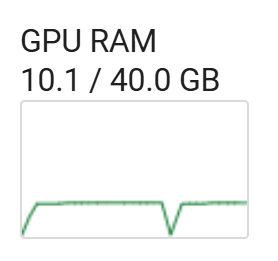

In [ ]:
gpu = "A100"
gpu_memory = "39.564 GB"
gpu_batch_size = 16


'\ngpu_mem_model="4.78 GB"\ngpu_mem_forward_pass="4.78 GB"\ngpu_mem_lora = "6.11 GB"\ngpu_mem_train = "9.85 GB"\n'

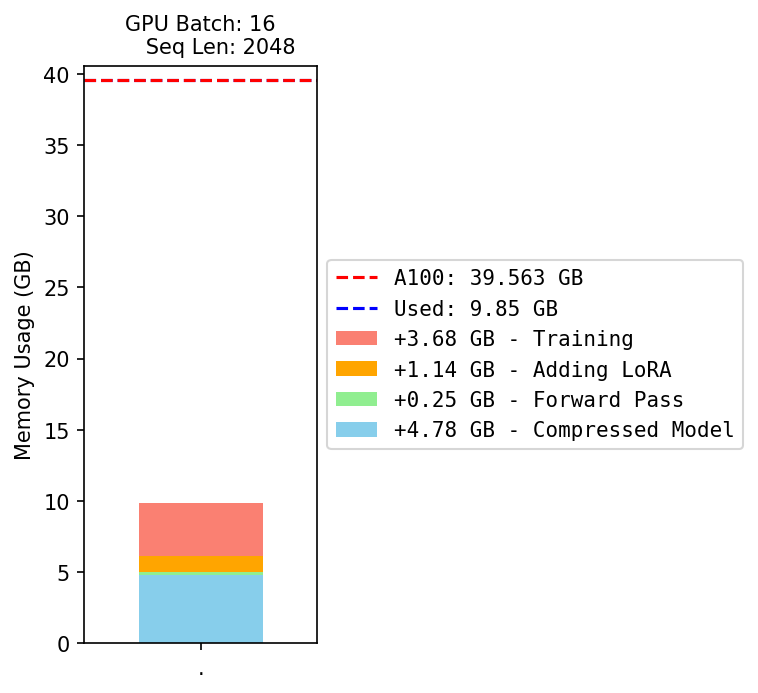

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the string values to floats
gm_model = float(gpu_mem_model.split()[0])
gm_forward_pass = float(gpu_mem_forward_pass.split()[0])
gm_lora = float(gpu_mem_lora.split()[0])
gm_train = float(gpu_mem_train.split()[0])
gm_total = float(gpu_memory.split()[0])

# Calculate the incremental memory added by each step
memory_additions = [
    gm_model,  # Compressed Model
    gm_forward_pass - gm_model,  # Forward Pass
    gm_lora - gm_forward_pass,   # Adding LoRA
    gm_train - gm_lora           # Training
]

# Update labels with memory added information
labels = [
    f'+{memory_additions[0]:.2f} GB - Compressed Model',
    f'+{memory_additions[1]:.2f} GB - Forward Pass',
    f'+{memory_additions[2]:.2f} GB - Adding LoRA',
    f'+{memory_additions[3]:.2f} GB - Training'
]

# Create a stacked bar plot with updated labels and proper y-limit
fig, ax = plt.subplots(figsize=(2, 5), dpi=150)  # Reduced figure width for a narrower bar, higher resolution

# Plot a horizontal line representing total used.
ax.axhline(y=gm_total, color='b', linestyle='--', label=f'Used: {gpu_mem_train}')

# Plot a horizontal line representing the total GPU memory available.
ax.axhline(y=gm_total, color='r', linestyle='--', label=f'{gpu:>4}: {gpu_memory}')

# Use a stacked bar chart where each bar adds to the total
ax.bar(".", memory_additions[0], label=labels[0], color='skyblue')
ax.bar(".", memory_additions[1], bottom=memory_additions[0], label=labels[1], color='lightgreen')
ax.bar(".", memory_additions[2], bottom=memory_additions[0] + memory_additions[1], label=labels[2], color='orange')
ax.bar(".", memory_additions[3], bottom=memory_additions[0] + memory_additions[1] + memory_additions[2], label=labels[3], color='salmon')


# Adjust the y-limit to make sure the total GPU memory line is visible
ax.set_ylim(0, gm_total + 1)  # Add some space above the total GPU memory

# Add labels and title
ax.set_ylabel('Memory Usage (GB)', fontsize=10)
ax.set_title('GPU Batch: {:}\n      Seq Len: {:}'.format(gpu_batch_size, max_seq_length), fontsize=10)

# Reverse the legend order to match the order of the bars, and move it outside the plot
handles, labels = ax.get_legend_handles_labels()

handles = list(reversed(handles))
reversed_labels = list(reversed(labels))

handles = handles[-2:] + handles[:-2]
reversed_labels = reversed_labels[-2:] + reversed_labels[:-2]

ax.legend(handles,
          reversed_labels,
          loc='center left', bbox_to_anchor=(1, 0.5),
          prop={'size': 10, 'family': 'monospace'})

# Adjust x-axis to make the single bar narrower visually
ax.set_xlim(-0.75, 0.75)

ax.tick_params(axis='y', labelsize=10)  # Adjust '8' to your desired font size

# Show the plot
plt.show()

## Other Inputs

In [ ]:
input_text = """# Setting the maximum width for printed text.
max_print_width = 80

# We'll track the character count of the current line. Testinnggggggggggggggggggggg
line_length = 0

# Starting the thread to begin text generation (i.e., invoke `model.generate`)
thread.start()

# Looping through the streamed text output.
for j, new_text in enumerate(text_streamer):
"""

In [ ]:
import textwrap

# Split the input text into lines based on existing newlines
lines_with_newlines_preserved = []
for line in input_text.splitlines():
    # Wrap each line separately and add it to the result list
    wrapped_lines = textwrap.wrap(
        line,
        width=max_print_width,
        drop_whitespace=False
    )
    lines_with_newlines_preserved.extend(wrapped_lines or [''])  # Preserve empty lines

# Get the length of the final line.
line_length = len(lines_with_newlines_preserved[-1])

# Join the wrapped lines with newline characters
result = '\n'.join(lines_with_newlines_preserved)

In [ ]:
print(result)

# Setting the maximum width for printed text.
max_print_width = 80

# We'll track the character count of the current line. 
Testinnggggggggggggggggggggg
line_length = 0

# Starting the thread to begin text generation (i.e., invoke `model.generate`)
thread.start()

# Looping through the streamed text output.
for j, new_text in enumerate(text_streamer):


In [ ]:
# Use `textwrap` to split the input text into multiple lines.
# It returns a list of strings (one per line)
lines = textwrap.wrap(
    input_text,
    width = max_print_width,
    drop_whitespace = False # Make sure it doesn't strip the space off
                            # the end of the last line.
)

print(lines)


["# Setting the maximum width for printed text. max_print_width = 80  # We'll ", 'track the character count of the current line. Testinnggggggggggggggggggggg ', 'line_length = 0  # Starting the thread to begin text generation (i.e., invoke ', '`model.generate`) thread.start()  # Looping through the streamed text output. ', 'for j, new_text in enumerate(text_streamer): ']


```
<s> # Setting the maximum width for printed text.  max_print_width = 80    #
We'll track the character count of the current line.  line_length = 0    #
Starting the thread to begin text generation (i.e., invoke `model.generate`)  
thread.start()    # Looping through the streamed text output.  for j, new_text
in enumerate(text_streamer):     # If the line is too long, we'll break it up
into two lines.

   if line_length + len(new_text) > max_print_width:

       # We'll print the first part of the line.

       print(text[:line_length])

       # We'll set the line length to zero.

       line_length = 0



   # We'll add the new text to the line.

   line_length += len(new_text)



   # We'll print the second part of the line.

   print(text[line_length:])</s>
```

## rsLoRA Plot

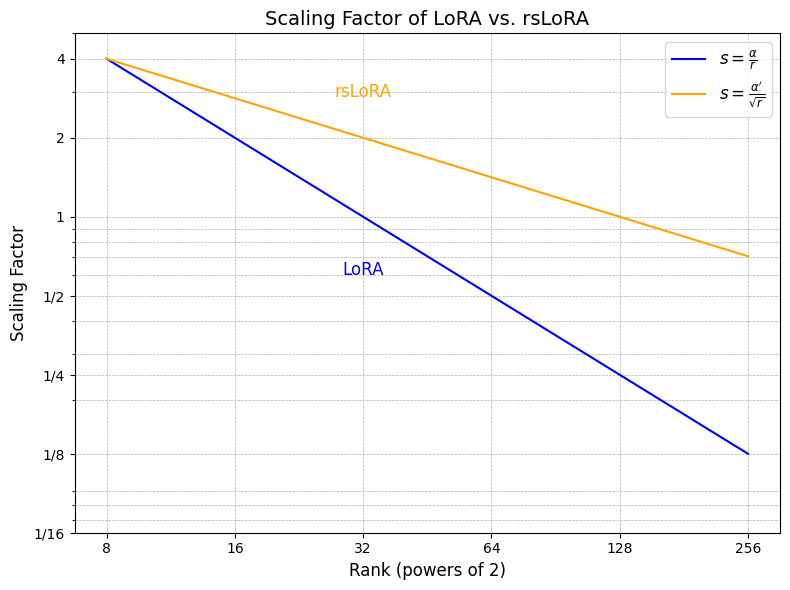

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define r values (logarithmic base 2)
r = np.logspace(np.log2(8), np.log2(256), base=2, num=500)

# Define s values
s1 = 32 / r
s2 = 11.313 / np.sqrt(r)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r, s1, label=r"$s = \frac{\alpha}{r}$", color='blue')
plt.plot(r, s2, label=r"$s = \frac{\alpha' }{\sqrt{r}}$", color='orange')

# Add annotations for LoRA and rsLoRA
plt.text(32, 5/8, "LoRA", color='blue', fontsize=12, ha='center', va='center')
plt.text(32, 3, "rsLoRA", color='orange', fontsize=12, ha='center', va='center')

# Set x-axis to logarithmic with base 2
plt.xscale('log', base=2)
plt.xticks([8, 16, 32, 64, 128, 256], labels=["8", "16", "32", "64", "128", "256"])

# Set y-axis to logarithmic with custom ticks and range
plt.yscale('log')
plt.ylim(3/32, 5)
plt.yticks([1/16, 1/8, 1/4, 1/2, 1, 2, 4], labels=["1/16", "1/8", "1/4", "1/2", "1", "2", "4"])

# Add labels and title
plt.xlabel("Rank (powers of 2)", fontsize=12)
plt.ylabel("Scaling Factor", fontsize=12)
plt.title("Scaling Factor of LoRA vs. rsLoRA", fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()
